# Fuzy Deep Cuts

The ellipsoid method is a method for showing that the polytope $P = \{x \in \mathbb{R}^n : Ax \geq b\}$ is non-empty. Here, $A$ is an $m \times n$ matrix with integer entries and $b$ is a vector of length $m$ also of integer entries.

Given a point $x' \in \mathbb{R}^n$, there must be some algorithm which is able to see if $a_i^T x' \geq b_i$ for all $i \in \mathbb{N}_m$. That is, we must be able to find the violated row constraints.

Classically, this is done by simply computing each inner product directly, which takes $\mathcal{O}(mn \textbf{ log}_2(U))$ itterations in the worst case. Here, $U$ is the largest magnitude entry of either $A$ or $b$.

Using a quantum computer, we can instead calculate the inner product of each of the rows simultaniously. Unfortunately, by the nature of quantum states, we cannot observe these calculations directly and must instead rely upon Quantum Tomography to reconstrut each state.

Let $M = \lceil \textbf{log}_2(m) \rceil$ and $N = \lceil \textbf{log}_2(n) \rceil$, so that the data may be encoded as quantum states. The circuit below relies upon QRAM being able to encode the state $| a_i \rangle$ when given the state $| i \rangle$ as an input. The circuit is made of three registers. The first is the ancilia qubit, the second is the index register, and the third is the vector register. The probability that the first register measures $| 0 \rangle$ will be $\frac{1}{2}(1+\langle a_i|x \rangle)$.

Therefore, using quantum tomography, we can reconstruct $\langle a_i | x \rangle$ for each $i$. Additionally, we can do this up to arbitrary persision $\epsilon$ using $\mathcal{O}(\frac{m}{\epsilon^2})$ shots. This will give an advantage over the classical case so long as $\mathcal{O}(\frac{1}{\epsilon^2}) \leq \mathcal{O}(n\textbf{ log}_2(U))$. This variable precision is why the term "fuzy" is used. The "deep cut" is used because we are able to see which constaint is the most violated, that is the index $i$ for which $b - a_i^T x$ is largest. If all constraints are feasible, then $\forall i \in \mathbb{N}_m; b_i - a_i^T x \leq 0$.

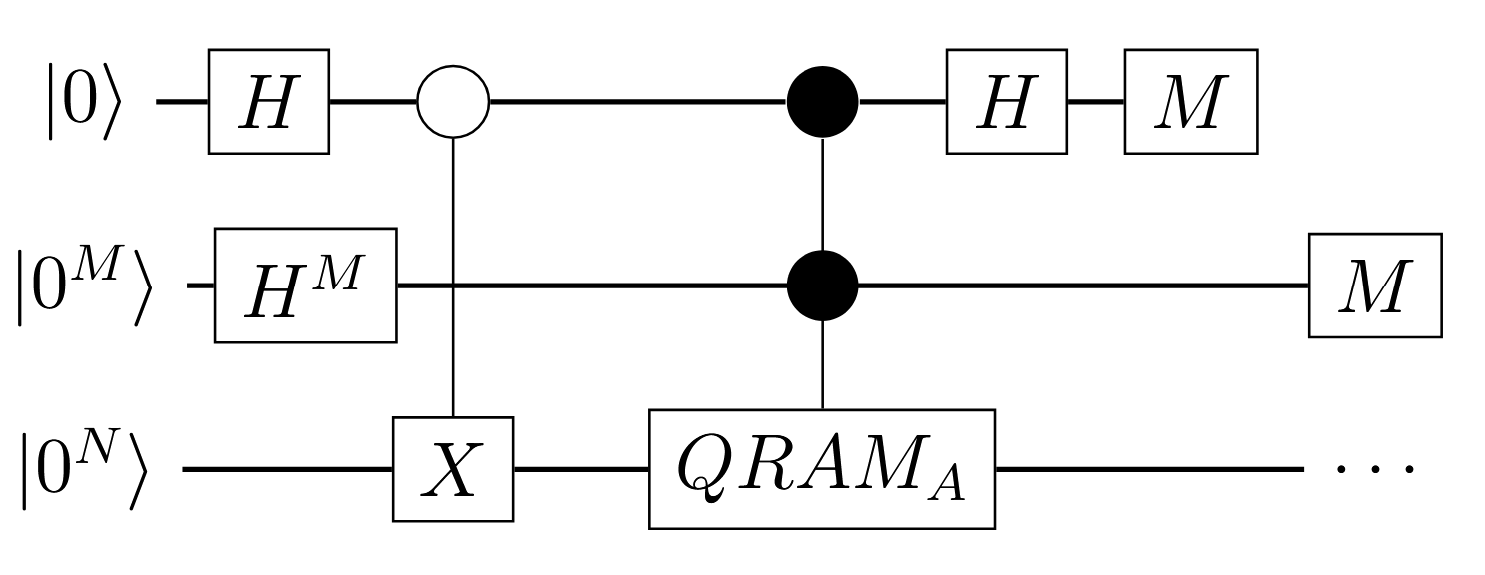

In [2]:
from qiskit import *
from qiskit.circuit.library import StatePreparation
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import HamiltonianGate
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
simulator = AerSimulator()

import numpy as np
from numpy import linalg
import math
import scipy.linalg as la
import random as rd

from sympy import Matrix
from sympy.physics.quantum import TensorProduct

import matplotlib.pyplot as plt

In [115]:
# Creates a unitary which encodes the state |v>
def create_unitary(v):
    return np.hstack((v,la.null_space(v.T)))

# Toy Problem

Here, we construct the simplest problem this circuit could possibly solve. It will work on a single qubit and a single constraint. 

We want to determine if for $A = \begin{pmatrix} 0 & 1 \end{pmatrix}x \geq \begin{pmatrix} 0.5 \end{pmatrix}$ has a feasible solution. Thefore, our $a_0 = | 1 \rangle$ and we initialize with $x =  | 0 \rangle$.

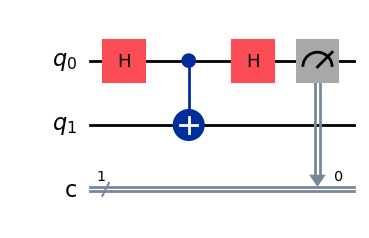

In [11]:
qc = QuantumCircuit(2,1)

# Entangle the Auxilary Qubit
qc.h(0)

# Entangle the x-state(nothing since x = |0>)

# Entangle the a_i
qc.cx(0,1)

# Un-H-gate
qc.h(0)

# Measurement
qc.measure(0,0)

qc.draw(output='mpl')

In [92]:
job = transpile(qc,backend=simulator)

# Shots = $\epsilon^2$. Since it's 100^2, we can be confident upto the 2nd decimal place.
shots = 10000

result = simulator.run(job, shots=shots).result()

# Since the probability of measuring 0 is 0.5(1+inner_prod), we rescale just to give us the inner products
(2*result.get_counts(qc)['0']-shots)/shots

-0.0024

# Multiple Constraint Toy Problem

$A = 
\begin{pmatrix}
    1 & 0\\
    0 & 1\\
    \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}\\
    1 & 0\\
\end{pmatrix} x \geq
\begin{pmatrix}
    \frac{1}{6} \\
    \frac{1}{6} \\
    \frac{1}{2} \\
    0\\
\end{pmatrix}$.

Here, the last constraint is a dummy constraint used to ensure $M$ is a power of 2

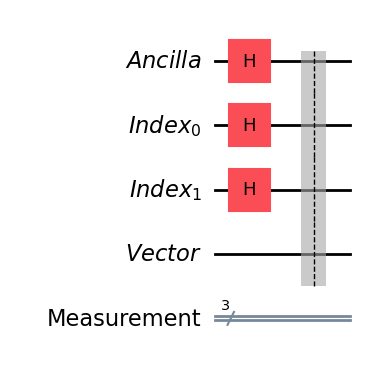

In [114]:
# Preping the different Registers and then creating the circuit
Ancilla = QuantumRegister(1, name='Ancilla')
Index = QuantumRegister(2, name='Index')
Vector = QuantumRegister(1, name='Vector')

Measure = ClassicalRegister(3, name='Measurement')

qc = QuantumCircuit(Ancilla, Index, Vector, Measure)

# Hadamard Gates
qc.h(0)
qc.h([1,2])

# Encoding

qc.barrier(label = ' ')

qc.draw(output='mpl')